### Data sorting
Make a train, validation and test data folders

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, shutil 

original_dataset_path = './data'

base_path = './melanoma_nevus'
if not os.path.isdir(base_path): os.mkdir(base_path)

# Make a new folders
train_folder = os.path.join(base_path, 'train')
if not os.path.isdir(train_folder): os.mkdir(train_folder)
validation_folder = os.path.join(base_path, 'validation')
if not os.path.isdir(validation_folder): os.mkdir(validation_folder)
test_folder = os.path.join(base_path, 'test')
if not os.path.isdir(test_folder): os.mkdir(test_folder)

train_melanoma_folder = os.path.join(train_folder, 'melanoma')
if not os.path.isdir(train_melanoma_folder): os.mkdir(train_melanoma_folder)
train_nevus_folder = os.path.join(train_folder, 'nevus')
if not os.path.isdir(train_nevus_folder): os.mkdir(train_nevus_folder)


validation_melanoma_folder = os.path.join(validation_folder, 'melanoma')
if not os.path.isdir(validation_melanoma_folder): os.mkdir(validation_melanoma_folder)
validation_nevus_folder = os.path.join(validation_folder, 'nevus')
if not os.path.isdir(validation_nevus_folder): os.mkdir(validation_nevus_folder)

test_melanoma_folder = os.path.join(test_folder, 'melanoma')
if not os.path.isdir(test_melanoma_folder): os.mkdir(test_melanoma_folder)
test_nevus_folder = os.path.join(test_folder, 'nevus')
if not os.path.isdir(test_nevus_folder): os.mkdir(test_nevus_folder)


In [2]:
# Get filenames for melanoma and nevus
melanoma_path = os.path.join(original_dataset_path, '1')
nevus_path = os.path.join(original_dataset_path, '0')

melanoma_filenames = [f for f in os.listdir(melanoma_path) if os.path.isfile(os.path.join(melanoma_path, f))]
nevus_filenames = [f for f in os.listdir(nevus_path) if os.path.isfile(os.path.join(nevus_path, f))]

In [3]:
from multiprocessing import Pool
from tqdm import tqdm

def save_processed_files(src_dst):
    img = image.load_img(src_dst[0])
    y = preprocess(np.array(img))
    image.save_img(src_dst[1],y)
    

# Copy images in to new folders
# split ratio (train, validation, test)
split_ratio = (0.7, 0.2, 0.1)

melanoma_src_dst = []
print("Melanoma files: {}".format(len(melanoma_filenames)))
for i in range(len(melanoma_filenames)):
    file_name = melanoma_filenames[i]
    
    src = os.path.join(melanoma_path, file_name)
    
    if i < split_ratio[0] * len(melanoma_filenames):
        # Train
        dst = os.path.join(train_melanoma_folder, file_name)
    elif i < split_ratio[0] * len(melanoma_filenames) + split_ratio[1] * len(melanoma_filenames):
        # Validation
        dst = os.path.join(validation_melanoma_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_melanoma_folder, file_name)
    
#     melanoma_src_dst+= [(src, dst)]
    shutil.copyfile(src, dst)

nevus_src_dst = []
print("Nevus files: {}".format(len(nevus_filenames)))
for i in range(len(nevus_filenames)):
    file_name = nevus_filenames[i]
    
    src = os.path.join(nevus_path, file_name)
    
    if i < split_ratio[0] * len(nevus_filenames):
        # Train
        dst = os.path.join(train_nevus_folder, file_name)
    elif i < split_ratio[0] * len(nevus_filenames) + split_ratio[1] * len(nevus_filenames):
        # Validation
        dst = os.path.join(validation_nevus_folder, file_name)
    else:
        # Test
        dst = os.path.join(test_nevus_folder, file_name)
    
#     nevus_src_dst+= [(src, dst)]
    shutil.copyfile(src, dst)
    
# pool = Pool()
# pool.map(save_processed_files, melanoma_src_dst), total=len(melanoma_src_dst)
# pool.map(save_processed_files, nevus_src_dst), total=len(nevus_src_dst)
    
print('-'*32)
print('Melanoma train:', len(os.listdir(train_melanoma_folder)))
print('Melanoma validation:', len(os.listdir(validation_melanoma_folder)))
print('Melanoma test:', len(os.listdir(test_melanoma_folder)))
print('Nevus train:', len(os.listdir(train_nevus_folder)))
print('Nevus validation:', len(os.listdir(validation_nevus_folder)))
print('Nevus test:', len(os.listdir(test_nevus_folder)))


Melanoma files: 1000
Nevus files: 1000
--------------------------------
Melanoma train: 700
Melanoma validation: 200
Melanoma test: 100
Nevus train: 700
Nevus validation: 200
Nevus test: 100


### Make image generator

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
SIZE = (244,244)

# Rescale image values from 0..255 to 0..1
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=180,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    shear_range=0.1,
#                                    zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder, 
    target_size = (SIZE[0],SIZE[1]),
    batch_size = 20,
    class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
    validation_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = 20,
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (SIZE[0],SIZE[1]), 
    batch_size = 20,
    class_mode = 'binary')

Found 1400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Network construction

In [14]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

1.15.2
Num GPUs Available:  1


### Transfer learning

In [26]:
import tensorflow
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(SIZE[0], SIZE[1], 3))

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
from tensorflow.keras import regularizers
# Augment conv_base
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))#, kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Freeze conv_base 
conv_base.trainable = False

model.compile(loss='binary_crossentropy', metrics=['acc'])



### Train model

In [31]:
callbacks_list = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0.001, patience=5),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='model.h5', monitor='val_loss',save_best_only=True)
]


history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = valid_generator,
    validation_steps = 50,
    callbacks=callbacks_list)

Epoch 1/20
100/100 [==============================] - 19s 193ms/step - loss: 0.8314 - acc: 0.5095 - val_loss: 0.6999 - val_acc: 0.4970
Epoch 2/20
100/100 [==============================] - 9s 89ms/step - loss: 0.7341 - acc: 0.5100 - val_loss: 0.7785 - val_acc: 0.4970
Epoch 3/20
100/100 [==============================] - 9s 88ms/step - loss: 0.7017 - acc: 0.5460 - val_loss: 0.8630 - val_acc: 0.4970
Epoch 4/20
100/100 [==============================] - 9s 85ms/step - loss: 0.6945 - acc: 0.5535 - val_loss: 0.8481 - val_acc: 0.5000
Epoch 5/20
100/100 [==============================] - 9s 88ms/step - loss: 0.6776 - acc: 0.5660 - val_loss: 0.8485 - val_acc: 0.5080
Epoch 6/20
100/100 [==============================] - 9s 86ms/step - loss: 0.6718 - acc: 0.5800 - val_loss: 0.9753 - val_acc: 0.5060
Epoch 7/20
100/100 [==============================] - 9s 88ms/step - loss: 0.6580 - acc: 0.6070 - val_loss: 1.1298 - val_acc: 0.4910
Epoch 8/20
100/100 [==============================] - 8s 83ms/step 

### Fine tuning 

In [32]:
# 1. Add new layer 
# 2. Freeze base network
# 3. Train added layer
# 4. Unfreeze couple last layers of base network
# 5. Train this layers
import tensorflow
from tensorflow.keras.models import load_model
model = load_model('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
for layer in model.layers:
    if layer.name == 'resnet50':
        for l in layer.layers[165:]:
            layer.trainable = True
        for l in layer.layers[:165]:
            l.trainable = False

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

In [34]:
callbacks_list = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0.001, patience=7),
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='model.h5', monitor='val_loss',save_best_only=True)
]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=50,
    callbacks=callbacks_list)

Epoch 1/100
100/100 [==============================] - 23s 226ms/step - loss: 0.6774 - acc: 0.5750 - val_loss: 0.6980 - val_acc: 0.4950
Epoch 2/100
100/100 [==============================] - 9s 94ms/step - loss: 0.6758 - acc: 0.5845 - val_loss: 0.7036 - val_acc: 0.4980
Epoch 3/100
100/100 [==============================] - 9s 94ms/step - loss: 0.6635 - acc: 0.6155 - val_loss: 0.7040 - val_acc: 0.4930
Epoch 4/100
100/100 [==============================] - 9s 93ms/step - loss: 0.6588 - acc: 0.6190 - val_loss: 0.6993 - val_acc: 0.5020
Epoch 5/100
100/100 [==============================] - 9s 95ms/step - loss: 0.6552 - acc: 0.6320 - val_loss: 0.7015 - val_acc: 0.4960
Epoch 6/100
100/100 [==============================] - 9s 93ms/step - loss: 0.6472 - acc: 0.6420 - val_loss: 0.6999 - val_acc: 0.4990
Epoch 7/100
100/100 [==============================] - 10s 96ms/step - loss: 0.6432 - acc: 0.6595 - val_loss: 0.7016 - val_acc: 0.4970
Epoch 8/100
100/100 [==============================] - 9s 9

### Test model

In [14]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test acc:", test_acc)
print("test loss:", test_loss)


test acc: 0.5
test loss: 0.8270989871025085


### Visualization of intermediate activations

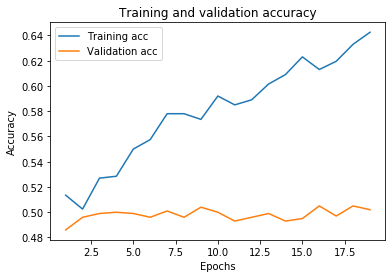

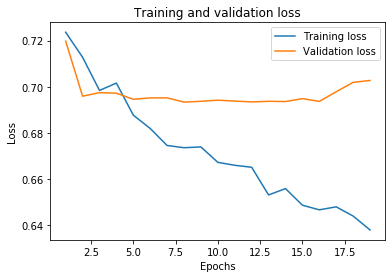

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

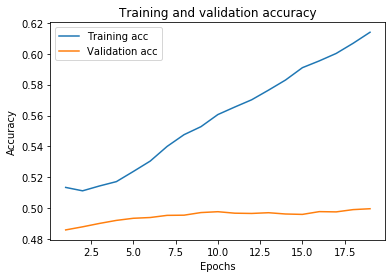

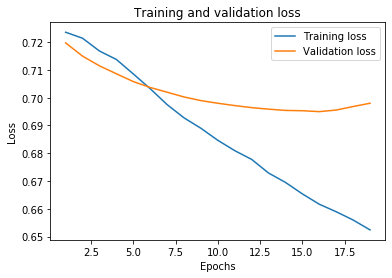

In [24]:
import matplotlib.pyplot as plt
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, smooth_curve(acc), label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()